In [9]:
from datasets import load_dataset
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import json
from datasets.utils.logging import disable_progress_bar
import torch
import gc
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sentence_transformers.quantization import quantize_embeddings
from sentence_transformers import export_dynamic_quantized_onnx_model
from sentence_transformers.util import cos_sim
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from collections import defaultdict
from wordcloud import WordCloud  # type: ignore

nltk.download("punkt")
nltk.download("stopwords")
disable_progress_bar()
plt.style.use('ggplot')
NUM_CORES = os.cpu_count()
print(f'Number of cores: {NUM_CORES}')
print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024 ** 3:.2f} GB")

Number of cores: 48
GPU memory: 44.46 GB


[nltk_data] Downloading package punkt to
[nltk_data]     /home/tau/ialiouch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tau/ialiouch/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
retrieval_results = pd.read_csv('rsrc/retrieval_results_2025-02-12_18-58-38.csv')
retrieval_results['size'] = retrieval_results['model'].apply(lambda x: 400 if 'stella' in x else 66 if 'gte' in x else 100 if 'e5' in x else 0)
retrieval_results['loss_fn'] = retrieval_results['model'].apply(lambda x:
                                                                "contrastive" if "-contrastive" in x
                                                                else "onlinecontrastive" if "-onlinecontrastive" in x
                                                                else "mnrl" if "-mnrl" in x
                                                                else "csmnrl" if "-csmnrl" in x
                                                                else None)
retrieval_results['model'] = retrieval_results['model'].apply(lambda x: x.split('-')[0] if 'TF' not in x else x)

In [3]:
retrieval_results

model       mrr    hits@1    hits@5   hits@10   hits@20  \
0                e5  0.372054  0.317739  0.435348  0.473684  0.500975   
1               gte  0.371179  0.317739  0.424301  0.469786  0.510721   
2               gte  0.405459  0.325536  0.480182  0.556855  0.645224   
3               gte  0.422930  0.343080  0.497076  0.576348  0.685510   
4                e5  0.371300  0.319038  0.430149  0.471735  0.511371   
5            stella  0.376053  0.324237  0.432749  0.465887  0.493827   
6                e5  0.397720  0.315140  0.481481  0.559454  0.649123   
7                e5  0.415862  0.333333  0.500975  0.580897  0.684860   
8               gte  0.370911  0.316439  0.424951  0.469786  0.510721   
9            stella  0.454642  0.378817  0.519818  0.597791  0.680962   
10           stella  0.438046  0.359324  0.505523  0.590643  0.686160   
11           stella  0.376743  0.324237  0.428850  0.466537  0.501624   
12  TF-IDF Baseline  0.234599  0.179337  0.284600  0.338532  0.404808   

        time  size            loss_fn  
0   0.004917   100  onlinecontrastive  
1   0.005829    66        contrastive  
2   0.006000    66             csmnrl  
3   0.005944    66               mnrl  
4   0.005151   100        contrastive  
5   0.034766   400        contrastive  
6   0.005012   100             csmnrl  
7   0.004952   100               mnrl  
8   0.005820    66  onlinecontrastive  
9   0.034750   400             csmnrl  
10  0.034688   400               mnrl  
11  0.034583   400  onlinecontrastive  
12  0.000030     0               None

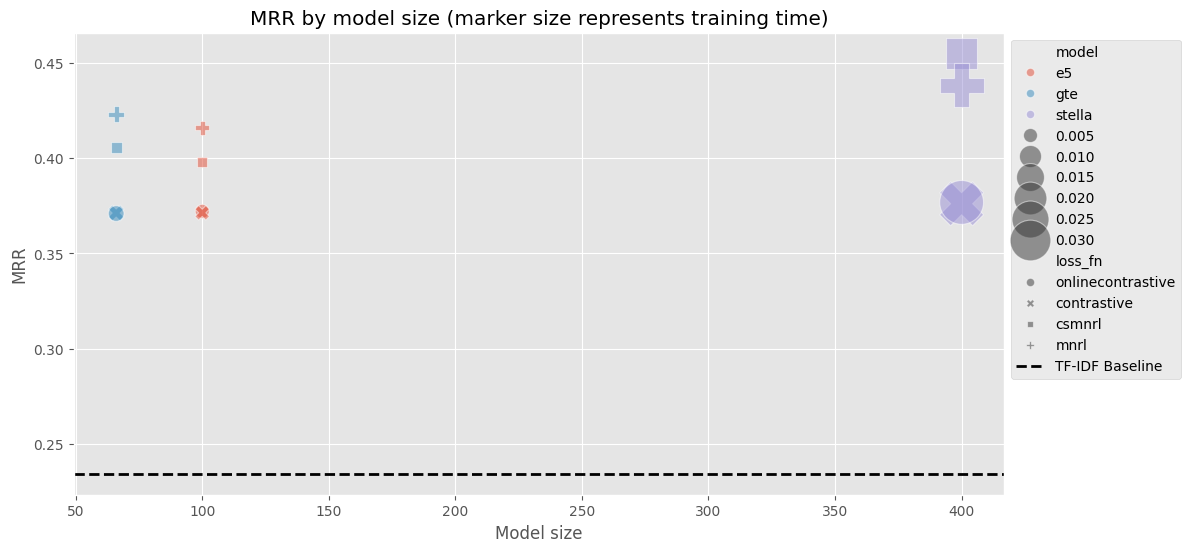

In [53]:
baseline_mrr = retrieval_results[retrieval_results["model"] == "TF-IDF Baseline"]["mrr"].values
baseline_mrr = baseline_mrr[0] if len(baseline_mrr) > 0 else None

df_models = retrieval_results[retrieval_results["model"] != "TF-IDF Baseline"]

plt.figure(figsize=(12, 6))

scatter = sns.scatterplot(
    data=df_models,
    x="size", 
    y="mrr",
    hue="model", 
    size="time",  
    sizes=(100, 1000),
    alpha=0.5,
    style="loss_fn"
)

if baseline_mrr is not None:
    plt.axhline(y=baseline_mrr, color="black", linestyle="--", linewidth=2, label="TF-IDF Baseline")

handles, labels = scatter.get_legend_handles_labels()
new_handles_labels = [(h, l) for h, l in zip(handles, labels) if not l.startswith("time")]
scatter.legend_.remove() 

plt.legend(*zip(*new_handles_labels), loc="upper left", bbox_to_anchor=(1, 1))

plt.xlabel("Model size")
plt.ylabel("MRR")
plt.title("MRR by model size (marker size represents training time)")
plt.grid(True)

plt.show()

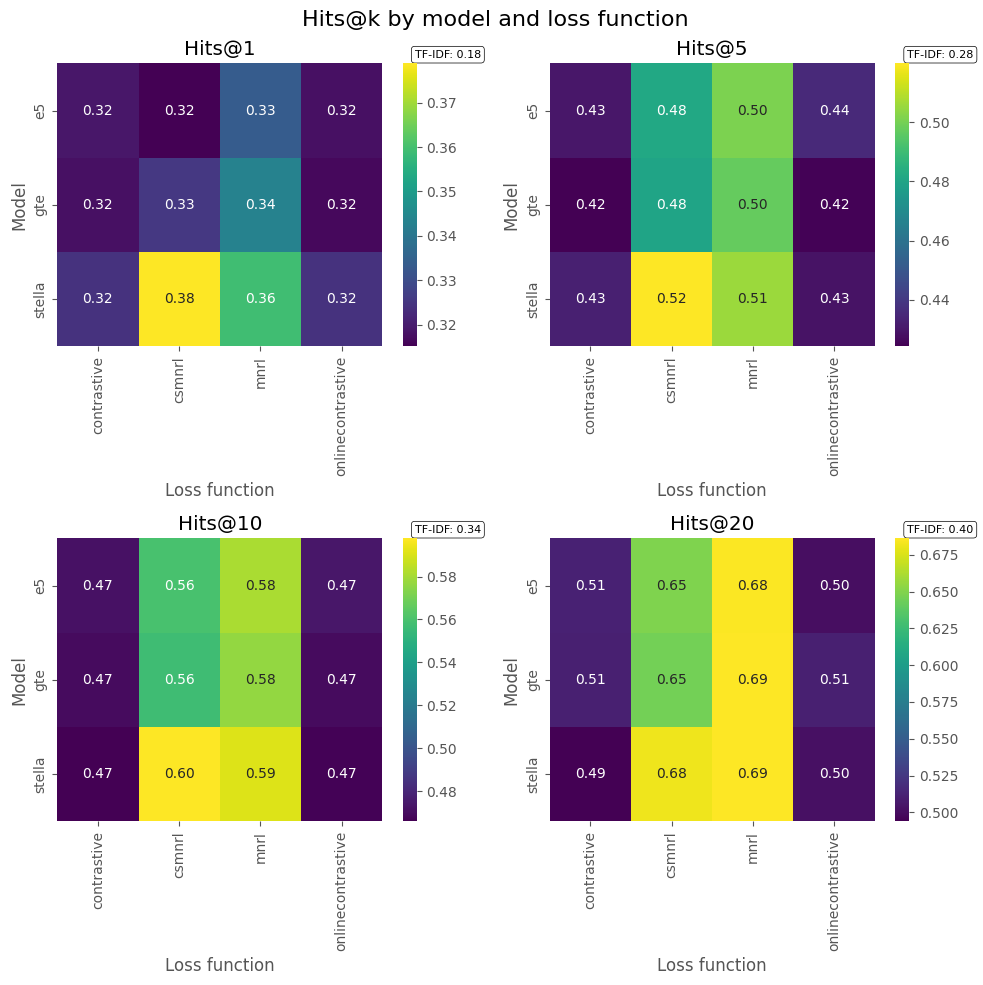

In [52]:
k_values = [1, 5, 10, 20]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

df_models = retrieval_results[retrieval_results["model"] != "TF-IDF Baseline"]

baseline_values = retrieval_results[retrieval_results["model"] == "TF-IDF Baseline"][[f"hits@{k}" for k in k_values]].values.flatten()

for i, k in enumerate(k_values):
    ax = axes[i // 2, i % 2]
    pivot_table = df_models.pivot(index="model", columns="loss_fn", values=f"hits@{k}")
    
    heatmap = sns.heatmap(pivot_table, cmap="viridis", annot=True, fmt=".2f", ax=ax, cbar=True)
    
    ax.set_title(f"Hits@{k}")
    ax.set_xlabel("Loss function")
    ax.set_ylabel("Model")

    if baseline_values.size > 0:
        baseline_value = baseline_values[i]
        ax.text(
            1.1, 1.02, f"TF-IDF: {baseline_value:.2f}", 
            transform=ax.transAxes, fontsize=8, color="black", 
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
        )

fig.suptitle("Hits@k by model and loss function", fontsize=16)
plt.tight_layout()
plt.show()

> The TF-IDF Baseline is largely outperformed.
>
> According to this two metrics, unsupervised contrastive learning seems to give better results in term of Information Retrieval.  
>
> The Hits@K metric shows us that the task is not easy because eve with K=20 with some samples we struggle to find the anchor.
>
> Perfromances are similar but **Stella + Multiple Negatives Ranking Loss** give the best results here.  
> If we take in account the time **GTE + Multiple Negatives Ranking Loss** looks good.  
>  
> Despite the tokenizer of the multilingual one (e5) was better, the performances are not very goods.

In [57]:
binary_results = pd.read_csv('rsrc/binary_results_2025-02-12_18-51-28.csv')
binary_results['size'] = binary_results['model'].apply(lambda x: 400 if 'stella' in x else 66 if 'gte' in x else 100 if 'e5' in x else 0)
binary_results['loss_fn'] = binary_results['model'].apply(lambda x:
                                                          "contrastive" if "-contrastive" in x
                                                          else "onlinecontrastive" if "-onlinecontrastive" in x
                                                          else "mnrl" if "-mnrl" in x
                                                          else "csmnrl" if "-csmnrl" in x
                                                          else None)
binary_results['model'] = binary_results['model'].apply(lambda x: x.split('-')[0] if 'TF' not in x else x)

binary_results = binary_results.drop(columns=['threshold'])

In [58]:
binary_results

model  accuracy        f1  precision   recall        ap       mcc  size  \
0       e5  0.905783  0.910092   0.891018  0.93000  0.969913  0.809163   100   
1      gte  0.907083  0.909994   0.903822  0.91625  0.972556  0.811246    66   
2      gte  0.832359  0.838390   0.830675  0.84625  0.913490  0.660148    66   
3      gte  0.840156  0.841085   0.870321  0.81375  0.919798  0.682222    66   
4       e5  0.904483  0.909315   0.897686  0.92125  0.969226  0.808762   100   
5   stella  0.933073  0.935905   0.931846  0.94000  0.982267  0.865924   400   
6       e5  0.816114  0.818182   0.826531  0.81000  0.897281  0.625587   100   
7       e5  0.834308  0.841121   0.838509  0.84375  0.912545  0.668023   100   
8      gte  0.907083  0.910559   0.904938  0.91625  0.972553  0.812543    66   
9   stella  0.881092  0.881707   0.912985  0.85250  0.949806  0.764269   400   
10  stella  0.845354  0.852723   0.844363  0.86125  0.923684  0.690116   400   
11  stella  0.932424  0.935644   0.926471  0.94500  0.982729  0.864711   400   

              loss_fn  
0   onlinecontrastive  
1         contrastive  
2              csmnrl  
3                mnrl  
4         contrastive  
5         contrastive  
6              csmnrl  
7                mnrl  
8   onlinecontrastive  
9              csmnrl  
10               mnrl  
11  onlinecontrastive

> The perfect metrics to compare here is the MCC, because it considers TN (in contrast to F1)

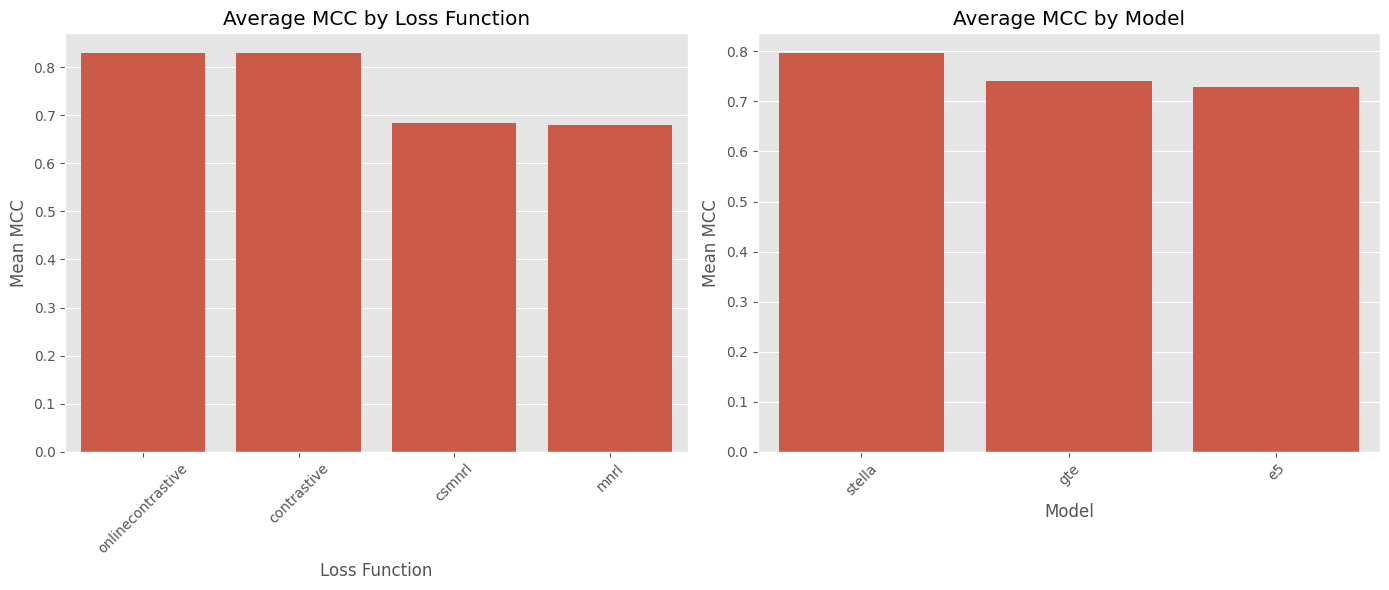

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

loss_fn_mcc = binary_results.groupby("loss_fn")["mcc"].mean().sort_values(ascending=False)
sns.barplot(x=loss_fn_mcc.index, y=loss_fn_mcc.values, ax=axes[0])
axes[0].set_title("Average MCC by Loss Function")
axes[0].set_xlabel("Loss Function")
axes[0].set_ylabel("Mean MCC")
axes[0].tick_params(axis='x', rotation=45)

model_mcc = binary_results.groupby("model")["mcc"].mean().sort_values(ascending=False)
sns.barplot(x=model_mcc.index, y=model_mcc.values, ax=axes[1],)
axes[1].set_title("Average MCC by Model")
axes[1].set_xlabel("Model")
axes[1].set_ylabel("Mean MCC")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

> It's surprising because here, supervised contrastive learning looks better than unsupervised.

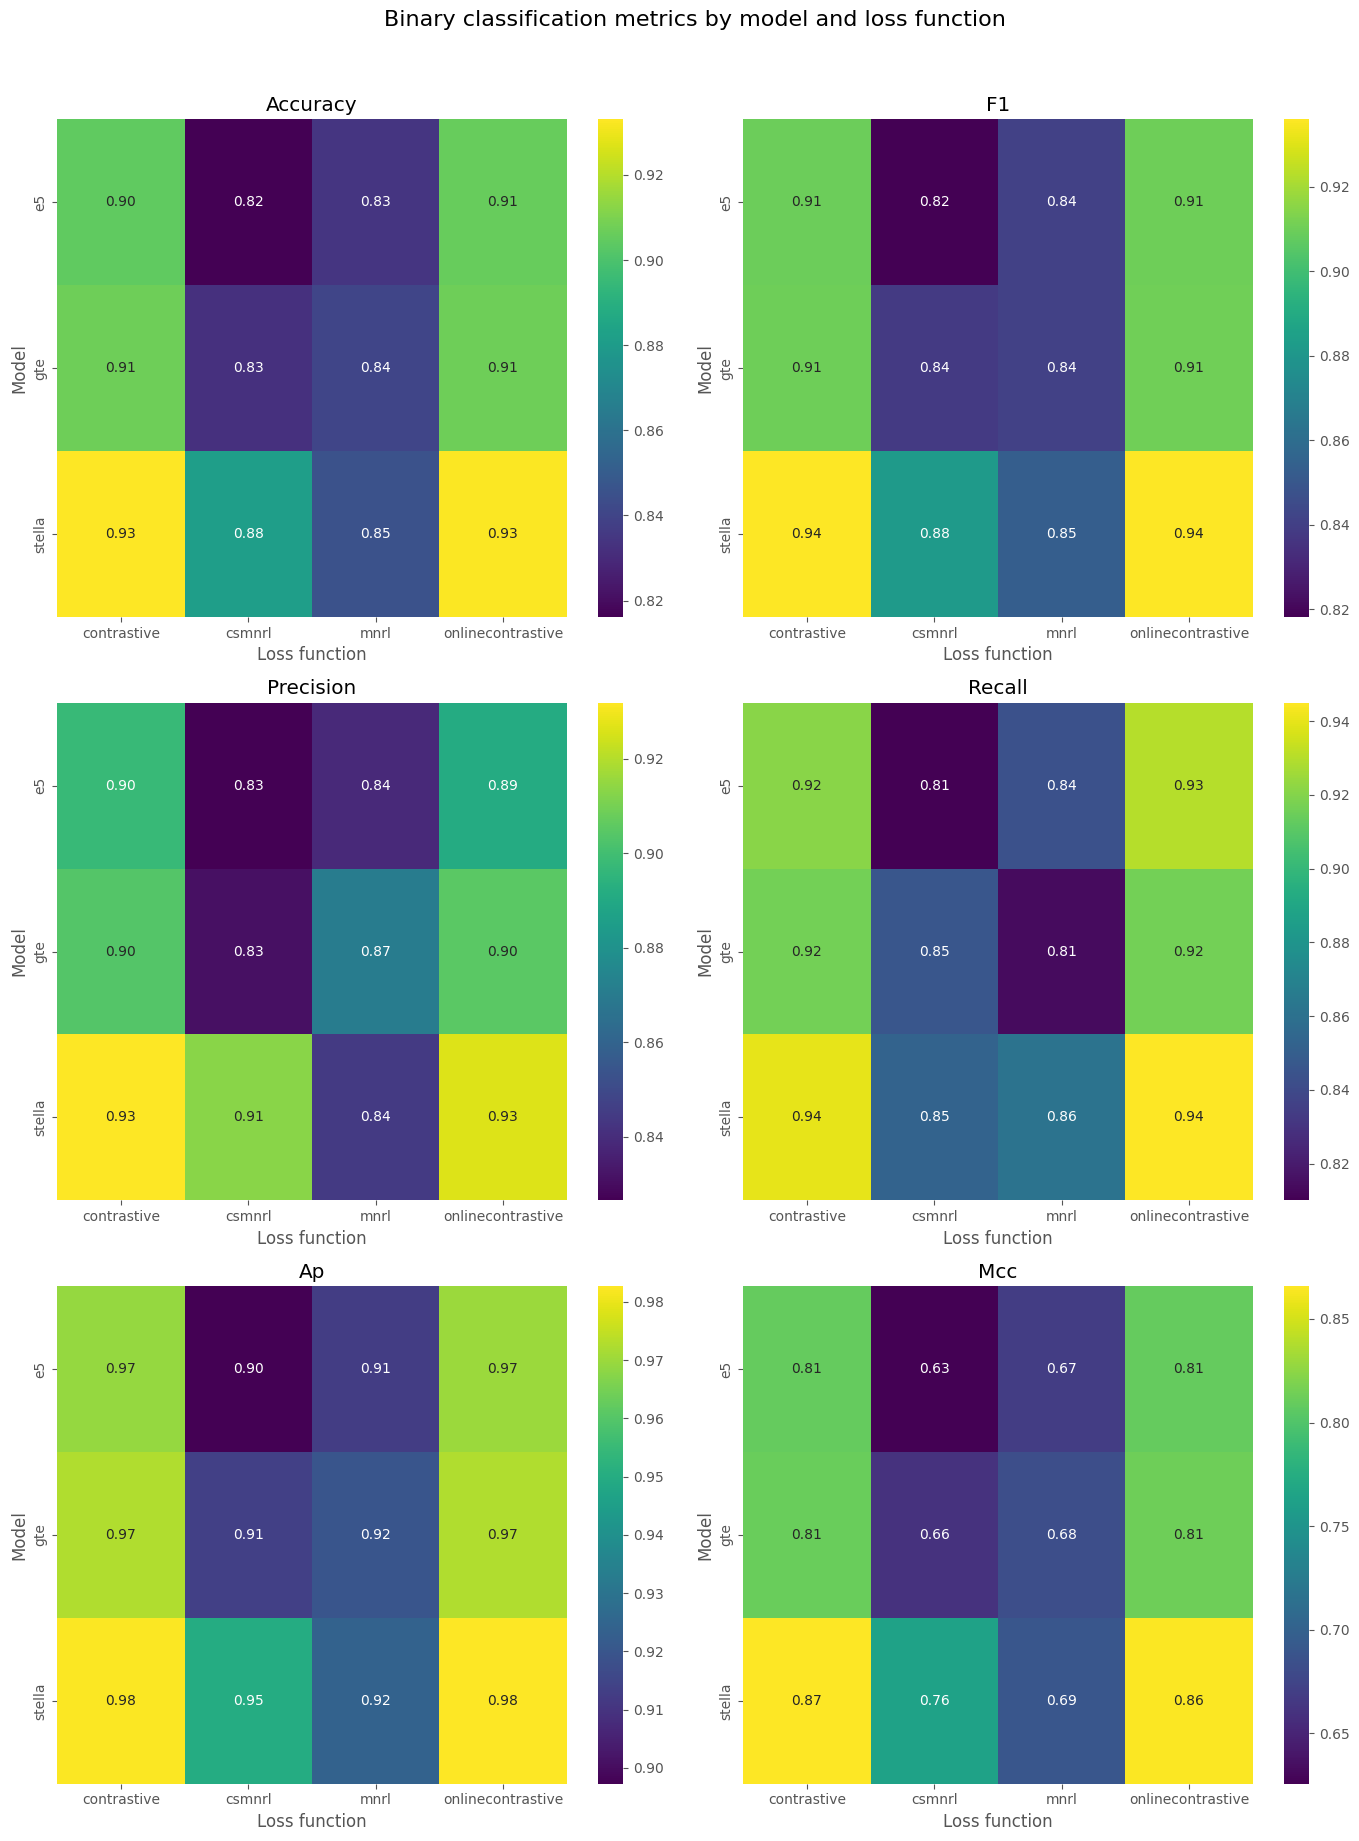

In [66]:
metrics = ["accuracy", "f1", "precision", "recall", "ap", "mcc"]
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

df_models = binary_results.pivot(index="model", columns="loss_fn", values=metrics)

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    pivot_table = binary_results.pivot(index="model", columns="loss_fn", values=metric)
    sns.heatmap(pivot_table, cmap="viridis", annot=True, fmt=".2f", ax=ax)
    
    ax.set_title(metric.capitalize())
    ax.set_xlabel("Loss function")
    ax.set_ylabel("Model")

fig.suptitle("Binary classification metrics by model and loss function", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

> Stella is slightly better than GTE, but even with only 66M of parameters, the metrics are good

In [6]:
CHECKPOINT_DIR = "./checkpoints"

MODELS_PATH = {
    model: os.path.join(CHECKPOINT_DIR, model, "best-model")
    for model in os.listdir(CHECKPOINT_DIR)
    if os.path.isdir(os.path.join(CHECKPOINT_DIR, model, "best-model"))
}

print(json.dumps(MODELS_PATH, indent=4))

{
    "e5-onlinecontrastive": "./checkpoints/e5-onlinecontrastive/best-model",
    "gte-contrastive": "./checkpoints/gte-contrastive/best-model",
    "gte-csmnrl": "./checkpoints/gte-csmnrl/best-model",
    "gte-mnrl": "./checkpoints/gte-mnrl/best-model",
    "e5-contrastive": "./checkpoints/e5-contrastive/best-model",
    "stella-contrastive": "./checkpoints/stella-contrastive/best-model",
    "e5-csmnrl": "./checkpoints/e5-csmnrl/best-model",
    "e5-mnrl": "./checkpoints/e5-mnrl/best-model",
    "gte-onlinecontrastive": "./checkpoints/gte-onlinecontrastive/best-model",
    "stella-csmnrl": "./checkpoints/stella-csmnrl/best-model",
    "stella-mnrl": "./checkpoints/stella-mnrl/best-model",
    "stella-onlinecontrastive": "./checkpoints/stella-onlinecontrastive/best-model",
    "gte-mat-mnrl": "./checkpoints/gte-mat-mnrl/best-model"
}


In [5]:
ds = load_dataset("WhereIsAI/github-issue-similarity", "default")["test"]

ds = ds.rename_columns({"text1": "sentence1", "text2": "sentence2"})

def remove_html_tags(sample):
    sample["sentence1"] = BeautifulSoup(sample["sentence1"], "html.parser").get_text().strip()
    sample["sentence2"] = BeautifulSoup(sample["sentence2"], "html.parser").get_text().strip()
    return sample

ds = ds.filter(lambda x: x["sentence1"] != "" and x["sentence2"] != "")

ds = ds.map(remove_html_tags, num_proc=NUM_CORES//2)

In [75]:
print(ds)

Dataset({
    features: ['sentence1', 'sentence2', 'label'],
    num_rows: 1539
})


In [7]:
def generate_embeddings(dataset, models_dict):

    sentences1 = dataset["sentence1"]
    sentences2 = dataset["sentence2"]
    
    for model_name, model_path in models_dict.items():
        print(f"Processing model: {model_name}")

        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {device}")
        model = SentenceTransformer(model_path, device=device, trust_remote_code=True)

        all_sentences = sentences1 + sentences2
        embeddings = model.encode(all_sentences, convert_to_tensor=True, batch_size=16, show_progress_bar=False)

        embeddings1 = embeddings[:len(sentences1)].cpu().numpy()
        embeddings2 = embeddings[len(sentences1):].cpu().numpy()

        dataset = dataset.add_column(f"{model_name}_embeddings1", embeddings1.tolist())
        dataset = dataset.add_column(f"{model_name}_embeddings2", embeddings2.tolist())
    

        del model, embeddings
        torch.cuda.empty_cache()
        gc.collect()

    return dataset

In [8]:
GTE_MODELS = {"gte-contrastive": "./checkpoints/gte-contrastive/best-model",
              "gte-mnrl": "./checkpoints/gte-mnrl/best-model"
}

In [9]:
ds_gte = generate_embeddings(ds, GTE_MODELS)

Processing model: gte-contrastive
Using device: cuda
Processing model: gte-mnrl
Using device: cuda


In [21]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 296916 KiB |    851 MiB |    862 GiB |    862 GiB |
|       from large pool | 292992 KiB |    843 MiB |    845 GiB |    845 GiB |
|       from small pool |   3924 KiB |     19 MiB |     17 GiB |     17 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 296916 KiB |    851 MiB |    862 GiB |    862 GiB |
|       from large pool | 292992 KiB |    843 MiB |    845 GiB |

In [22]:
print(ds_gte)

Dataset({
    features: ['sentence1', 'sentence2', 'label', 'gte-contrastive_embeddings1', 'gte-contrastive_embeddings2', 'gte-mnrl_embeddings1', 'gte-mnrl_embeddings2'],
    num_rows: 1539
})


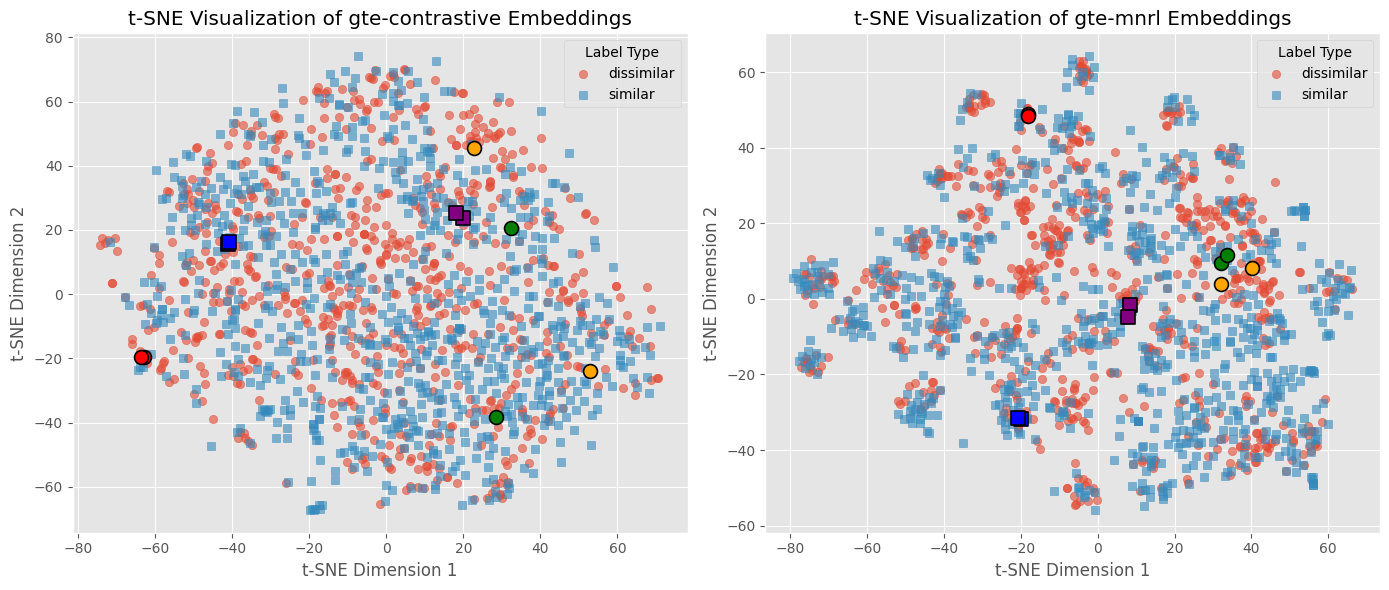

In [32]:
np.random.seed(42)

embedding_columns = [
    "gte-contrastive_embeddings1", "gte-contrastive_embeddings2", 
    "gte-mnrl_embeddings1", "gte-mnrl_embeddings2"
]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

highlight_indices = np.random.choice(len(ds_gte["sentence1"]), 5, replace=False)
highlight_colors = ["red", "blue", "green", "purple", "orange"]

for i in range(2):
    emb_1 = np.array(ds_gte[embedding_columns[i * 2]])  
    emb_2 = np.array(ds_gte[embedding_columns[i * 2 + 1]])  
    labels = np.array(ds_gte["label"])  

    embeddings = np.vstack((emb_1, emb_2))
    sentence_labels = ["sentence1"] * len(emb_1) + ["sentence2"] * len(emb_2)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    ax = axes[i]
    markers = {0: "o", 1: "s"}

    for label in [0, 1]:
        indices = np.where(labels == label)[0]
        ax.scatter(
            reduced_embeddings[indices, 0], 
            reduced_embeddings[indices, 1], 
            label="similar" if label == 1 else "dissimilar",
            alpha=0.6, 
            marker=markers[label]
        )

    for j, idx in enumerate(highlight_indices):
        marker = markers[labels[idx]]
        ax.scatter(
            reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], 
            color=highlight_colors[j], edgecolors="black", linewidth=1.2, s=100, marker=marker
        )
        ax.scatter(
            reduced_embeddings[len(emb_1) + idx, 0], reduced_embeddings[len(emb_1) + idx, 1], 
            color=highlight_colors[j], edgecolors="black", linewidth=1.2, s=100, marker=marker
        )

    ax.set_title(f"t-SNE Visualization of {embedding_columns[i * 2].split('_')[0]} Embeddings")
    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")
    ax.legend(title="Label Type")

plt.tight_layout()
plt.show()

> Obvisously the contrastive loss makes the distance between dissimilar pairs larger than MNR loss because of the utilization of the label. However, in a real use case/application this is not necessary a guarantee of quality, as we have seen with MRR and Hits@K

In [ ]:
GTE5_CONTR_MODELS = {"gte-contrastive": "./checkpoints/gte-contrastive/best-model",
                     "e5-contrastive": "./checkpoints/e5-contrastive/best-model"
}

ds_gte_e5 = generate_embeddings(ds, GTE5_CONTR_MODELS)

In [29]:
ds_gte_e5

Dataset({
    features: ['sentence1', 'sentence2', 'label', 'gte-contrastive_embeddings1', 'gte-contrastive_embeddings2', 'e5-contrastive_embeddings1', 'e5-contrastive_embeddings2'],
    num_rows: 1539
})

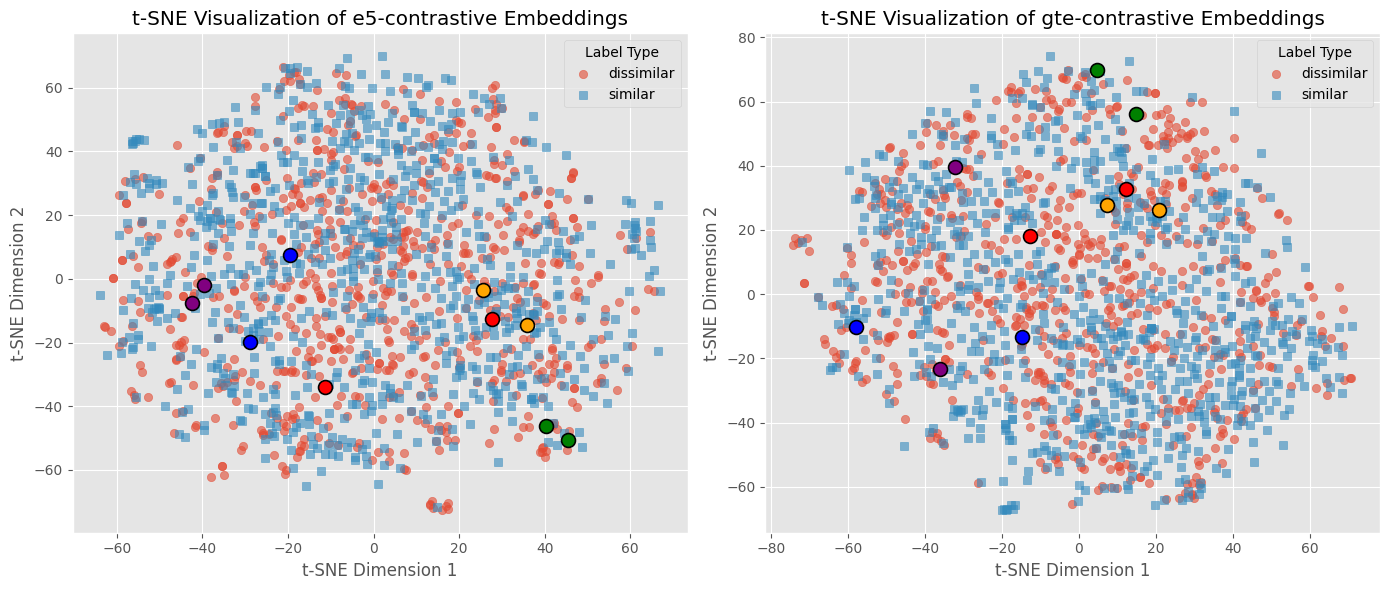

In [34]:
embedding_columns = [
    "e5-contrastive_embeddings1", "e5-contrastive_embeddings2", 
    "gte-contrastive_embeddings1", "gte-contrastive_embeddings2"
]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

highlight_indices = np.random.choice(len(ds_gte_e5["sentence1"]), 5, replace=False)
highlight_colors = ["red", "blue", "green", "purple", "orange"]

for i in range(2):
    emb_1 = np.array(ds_gte_e5[embedding_columns[i * 2]])  
    emb_2 = np.array(ds_gte_e5[embedding_columns[i * 2 + 1]])  
    labels = np.array(ds_gte_e5["label"])  

    embeddings = np.vstack((emb_1, emb_2))
    sentence_labels = ["sentence1"] * len(emb_1) + ["sentence2"] * len(emb_2)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    ax = axes[i]
    markers = {0: "o", 1: "s"}

    for label in [0, 1]:
        indices = np.where(labels == label)[0]
        ax.scatter(
            reduced_embeddings[indices, 0], 
            reduced_embeddings[indices, 1], 
            label=f"similar" if label == 1 else "dissimilar",
            alpha=0.6, 
            marker=markers[label]
        )

    for j, idx in enumerate(highlight_indices):
        marker = markers[labels[idx]]
        ax.scatter(
            reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], 
            color=highlight_colors[j], edgecolors="black", linewidth=1.2, s=100, marker=marker
        )
        ax.scatter(
            reduced_embeddings[len(emb_1) + idx, 0], reduced_embeddings[len(emb_1) + idx, 1], 
            color=highlight_colors[j], edgecolors="black", linewidth=1.2, s=100, marker=marker
        )

    ax.set_title(f"t-SNE Visualization of {embedding_columns[i * 2].split('_')[0]} Embeddings")
    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")
    ax.legend(title="Label Type")

plt.tight_layout()
plt.show()

> The distance between the dissimilar random pairs are greater with gte, indicating that the contrastive loss worked potentially better with this model

In [35]:
GTE_OOB = {
    "gte-oob": "prdev/mini-gte",
    "gte-contrastive": "./checkpoints/gte-contrastive/best-model"
}

ds_gte_oob = generate_embeddings(ds, GTE_OOB)

Processing model: gte-oob
Using device: cuda
Processing model: gte-contrastive
Using device: cuda


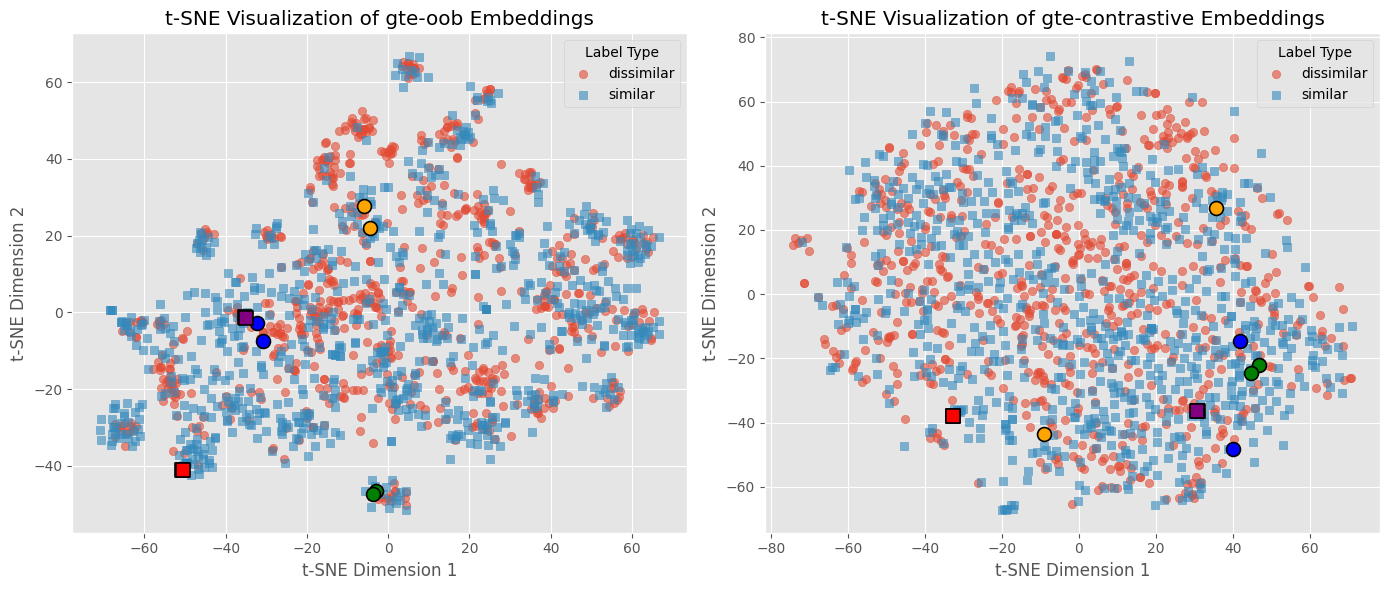

In [36]:
embedding_columns = [
    "gte-oob_embeddings1", "gte-oob_embeddings2", 
    "gte-contrastive_embeddings1", "gte-contrastive_embeddings2"
]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

highlight_indices = np.random.choice(len(ds_gte_oob["sentence1"]), 5, replace=False)
highlight_colors = ["red", "blue", "green", "purple", "orange"]

for i in range(2):
    emb_1 = np.array(ds_gte_oob[embedding_columns[i * 2]])  
    emb_2 = np.array(ds_gte_oob[embedding_columns[i * 2 + 1]])  
    labels = np.array(ds_gte_oob["label"])  

    embeddings = np.vstack((emb_1, emb_2))
    sentence_labels = ["sentence1"] * len(emb_1) + ["sentence2"] * len(emb_2)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    ax = axes[i]
    markers = {0: "o", 1: "s"}

    for label in [0, 1]:
        indices = np.where(labels == label)[0]
        ax.scatter(
            reduced_embeddings[indices, 0], 
            reduced_embeddings[indices, 1], 
            label=f"similar" if label == 1 else "dissimilar",
            alpha=0.6, 
            marker=markers[label]
        )

    for j, idx in enumerate(highlight_indices):
        marker = markers[labels[idx]]
        ax.scatter(
            reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], 
            color=highlight_colors[j], edgecolors="black", linewidth=1.2, s=100, marker=marker
        )
        ax.scatter(
            reduced_embeddings[len(emb_1) + idx, 0], reduced_embeddings[len(emb_1) + idx, 1], 
            color=highlight_colors[j], edgecolors="black", linewidth=1.2, s=100, marker=marker
        )

    ax.set_title(f"t-SNE Visualization of {embedding_columns[i * 2].split('_')[0]} Embeddings")
    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")
    ax.legend(title="Label Type")

plt.tight_layout()
plt.show()

> It's interesting because with the GTE model out of the box (without fine tuning), we can see with out samples that the distances of dissmilar ones is already greater than the distances of similar ones

> We will focus on **GTE + MNRL**, because what we want it's a model that can retrieve similar issues, and the MRR and Hits@K metrics are suited for evaluate that.  
> Why not Stella ? We trade some performance for inference/training time

> Let's analyze more deeper where our model is wrong

In [79]:
ds_gte

Dataset({
    features: ['sentence1', 'sentence2', 'label', 'gte-contrastive_embeddings1', 'gte-contrastive_embeddings2', 'gte-mnrl_embeddings1', 'gte-mnrl_embeddings2'],
    num_rows: 1539
})

In [80]:
ds_gte = ds_gte.remove_columns(['gte-contrastive_embeddings1', 'gte-contrastive_embeddings2'])

In [81]:
sim_gte = cos_sim(
        torch.tensor(ds_gte["gte-mnrl_embeddings1"]), 
        torch.tensor(ds_gte["gte-mnrl_embeddings2"])
    ).diagonal()
ds_gte = ds_gte.add_column(
    "sim",
    sim_gte.tolist()
)

In [82]:
print(ds_gte)

Dataset({
    features: ['sentence1', 'sentence2', 'label', 'gte-mnrl_embeddings1', 'gte-mnrl_embeddings2', 'sim'],
    num_rows: 1539
})


In [83]:
def cosine_similarity_loss(cos_sim, labels, alpha=1e-6):
    scaled_sim = (cos_sim + 1) / 2  # We normalize from [-1, 1] to [0, 1]

    loss_pos = -labels * torch.log(scaled_sim.clamp(min=alpha))  # if label 1, penalize if sim low
    loss_neg = -(1 - labels) * torch.log((1 - scaled_sim).clamp(min=alpha))  # if label 0, penalize if sim high

    return loss_pos + loss_neg

In [84]:
losses = cosine_similarity_loss(
    sim_gte,
    torch.tensor(ds_gte["label"]).float()
)

In [85]:
print(losses)

tensor([0.2078, 0.1911, 0.9334,  ..., 0.7754, 0.2454, 1.1123])


In [86]:
ds_gte = ds_gte.add_column("loss", losses.tolist())

In [87]:
ds_gte

Dataset({
    features: ['sentence1', 'sentence2', 'label', 'gte-mnrl_embeddings1', 'gte-mnrl_embeddings2', 'sim', 'loss'],
    num_rows: 1539
})

In [88]:
df_gte = ds_gte.to_pandas().sort_values("loss", ascending=False)

In [89]:
df_gte

sentence1  \
1226  Checklist\n\n I have verified that the issue e...   
1168  Checklist\n\n I have read the relevant section...   
465   Checklist\n\n I have included the output of ce...   
549   Hey, I am not able to get the help command wor...   
445   Apache Airflow version\n2.2.2\nWhat happened\n...   
...                                                 ...   
1003  Please go to Stack Overflow for help and suppo...   
250   SCRIPT5009: 'System' is undefined\nI am still ...   
1119  Describe the workflow you want to enable\nTo t...   
298   Add a flag to the codegen feature (i.e. --pom=...   
255   Steps to Reproduce\n\nEnter command: flutter c...   

                                              sentence2  label  \
1226  Checklist\n\n I have read the relevant section...      0   
1168  Checklist\n\n I have verified that the issue e...      0   
465   Checklist\n\n I have verified that the issue e...      0   
549   Checklist\n\n I have read the relevant section...      0   
445   Apache Airflow version: 1.10.8\nEnvironment:\n...      0   
...                                                 ...    ...   
1003  Please go to Stack Overflow for help and suppo...      1   
250   SCRIPT5009: 'System' is undefined\nI am still ...      1   
1119  Describe the workflow you want to enable\nTo t...      1   
298   Add a flag to the codegen feature (i.e. --pom=...      1   
255   Steps to Reproduce\n\nEnter command: flutter c...      1   

                                   gte-mnrl_embeddings1  \
1226  [-0.6410802006721497, 0.05019281804561615, -0....   
1168  [-0.9683588147163391, 0.1826690137386322, -0.1...   
465   [-0.9144493341445923, 0.1285952627658844, 0.66...   
549   [-0.9647858142852783, 0.18812061846256256, 0.2...   
445   [-0.1485777646303177, -0.22959363460540771, 0....   
...                                                 ...   
1003  [0.28853949904441833, -0.20516884326934814, -0...   
250   [0.17593245208263397, -0.3869485557079315, 0.0...   
1119  [-0.19061975181102753, -0.36843836307525635, 0...   
298   [0.5927903652191162, -0.3988954722881317, 0.14...   
255   [0.2866905927658081, -0.6624011993408203, -0.6...   

                                   gte-mnrl_embeddings2       sim  \
1226  [-0.9596682786941528, 0.16456308960914612, 0.0...  0.852811   
1168  [-0.811586320400238, 0.2046770602464676, 0.201...  0.803737   
465   [-0.8281170129776001, 0.21006964147090912, 0.1...  0.688162   
549   [-0.7222050428390503, 0.16764287650585175, -0....  0.681779   
445   [0.05576251074671745, -0.16166183352470398, 0....  0.667210   
...                                                 ...       ...   
1003  [0.28853949904441833, -0.20516884326934814, -0...  1.000000   
250   [0.17593245208263397, -0.3869485557079315, 0.0...  1.000000   
1119  [-0.19061975181102753, -0.36843836307525635, 0...  1.000000   
298   [0.5927907824516296, -0.3988957107067108, 0.14...  1.000000   
255   [0.2866905927658081, -0.6624011993408203, -0.6...  1.000000   

              loss  
1226  2.609182e+00  
1168  2.321449e+00  
465   1.858417e+00  
549   1.838155e+00  
445   1.793390e+00  
...            ...  
1003  0.000000e+00  
250   0.000000e+00  
1119  0.000000e+00  
298   0.000000e+00  
255  -1.192093e-07  

[1539 rows x 7 columns]

In [91]:
print(df_gte.iloc[1]["sentence1"])
print("*" * 80)
print("*" * 80)
print(df_gte.iloc[1]["sentence2"])

Checklist

 I have read the relevant section in the
contribution guide
on reporting bugs.
 I have checked the issues list
for similar or identical bug reports.
 I have checked the pull requests list
for existing proposed fixes.
 I have checked the commit log
to find out if the bug was already fixed in the master branch.
 I have included all related issues and possible duplicate issues
in this issue (If there are none, check this box anyway).

Mandatory Debugging Information

 I have included the output of celery -A proj report in the issue.
(if you are not able to do this, then at least specify the Celery
version affected).
 I have verified that the issue exists against the master branch of Celery.
 I have included the contents of pip freeze in the issue.
 I have included all the versions of all the external dependencies required
to reproduce this bug.

Optional Debugging Information

 I have tried reproducing the issue on more than one Python version
and/or implementation.
 I have tri

In [100]:
def preprocess_text(text):

    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    tokens = word_tokenize(text)
    
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    return tokens

def tokenize_and_loss(df, loss_col="loss"):

    token_loss_sum = defaultdict(float)
    token_count = defaultdict(int)

    for _, row in df.iterrows():
        tokens1 = preprocess_text(row["sentence1"])
        tokens2 = preprocess_text(row["sentence2"])
        loss = row[loss_col]

        for token in tokens1 + tokens2:
            token_loss_sum[token] += loss
            token_count[token] += 1

    token_loss_avg = {token: (token_loss_sum[token] / token_count[token], token_count[token]) for token in token_loss_sum}

    return token_loss_avg

In [101]:
token_loss = tokenize_and_loss(df_gte)

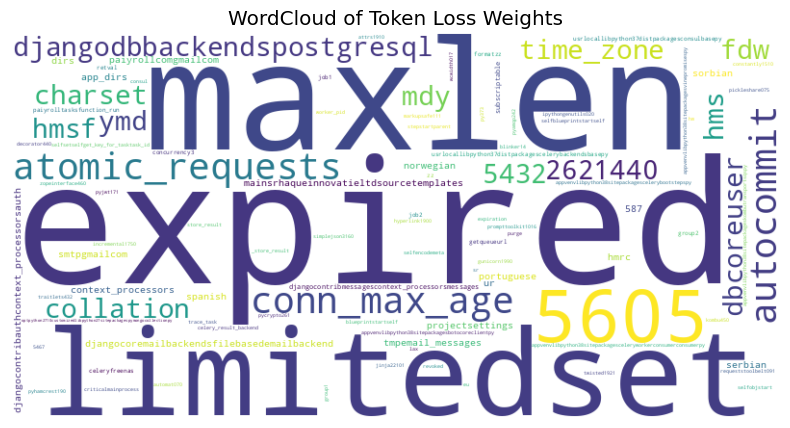

In [112]:
filtered_token_loss = {token: loss[0] for token, loss in token_loss.items() if loss[1] > 1}

wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate_from_frequencies(filtered_token_loss)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Token Loss Weights")
plt.show()

> Bigger words are the hardes ones with which the model struggle, if someone is motivated, he can look at the issues where these words are present and can try to explaine the reasons

In [10]:
binary_embeddings = quantize_embeddings(
    ds_gte["gte-mnrl_embeddings1"] + ds_gte["gte-mnrl_embeddings2"],
    precision="binary"
)

embeddings1 = binary_embeddings[:len(ds_gte["gte-mnrl_embeddings1"])]
embeddings2 = binary_embeddings[len(ds_gte["gte-mnrl_embeddings1"]):]

In [11]:
embeddings1[0]

array([  90,  -85,  110,  -98,   32,   10,  -61,   53,  -37,  -90,  -83,
         77,  -64,  107,  -44,  -92,  -22,  118,   11, -118,  -90,   62,
         52,   81,  -79,   56, -121,   22,   70,  -70,  -37,  102,  -99,
         57,   65,  -27,   51,  -68,   69,   26,  -31,   40,  -80,    8,
        -76,  -97,   41,  -54,  -40,   -7,  -22,   71,  -89,  -70,   12,
        -77,   83,   97,   -9,  -77,   74,  -47,   12,   81,  -55,  -26,
        -64,   18, -115,  -41,   19,  -88,   60,  -98,   86,   -1, -120,
         80, -108,  109,  -80,  -29,   86,   92,   88,  -55,  120,  -87,
         89,    0,  -31,  -47,   41,   19,   31,  112], dtype=int8)

In [12]:
ds_gte = ds_gte.add_column("binary_embeddings1", embeddings1.tolist())
ds_gte = ds_gte.add_column("binary_embeddings2", embeddings2.tolist())

In [13]:
ds_gte

Dataset({
    features: ['sentence1', 'sentence2', 'label', 'gte-contrastive_embeddings1', 'gte-contrastive_embeddings2', 'gte-mnrl_embeddings1', 'gte-mnrl_embeddings2', 'binary_embeddings1', 'binary_embeddings2'],
    num_rows: 1539
})

In [21]:
# cos_sim_full = cos_sim(
#     torch.tensor(ds_gte["gte-mnrl_embeddings1"]),
#     torch.tensor(ds_gte["gte-mnrl_embeddings2"])
# ).numpy()

%time
cos_sim_full = ds_gte["gte-mnrl_embeddings1"] @ np.array(ds_gte["gte-mnrl_embeddings2"]).T / (
    np.linalg.norm(ds_gte["gte-mnrl_embeddings1"], axis=1)[:, None] * np.linalg.norm(ds_gte["gte-mnrl_embeddings2"], axis=1)[None, :]
)

CPU times: user 9 μs, sys: 1 μs, total: 10 μs
Wall time: 18.4 μs


In [22]:
%time
cos_sim_binary = embeddings1 @ embeddings2.T /(np.linalg.norm(embeddings1, axis=1)[:, None] * np.linalg.norm(embeddings2, axis=1)[None, :])

CPU times: user 5 μs, sys: 1 μs, total: 6 μs
Wall time: 11 μs


In [23]:
cos_sim_full.shape, cos_sim_binary.shape

((1539, 1539), (1539, 1539))

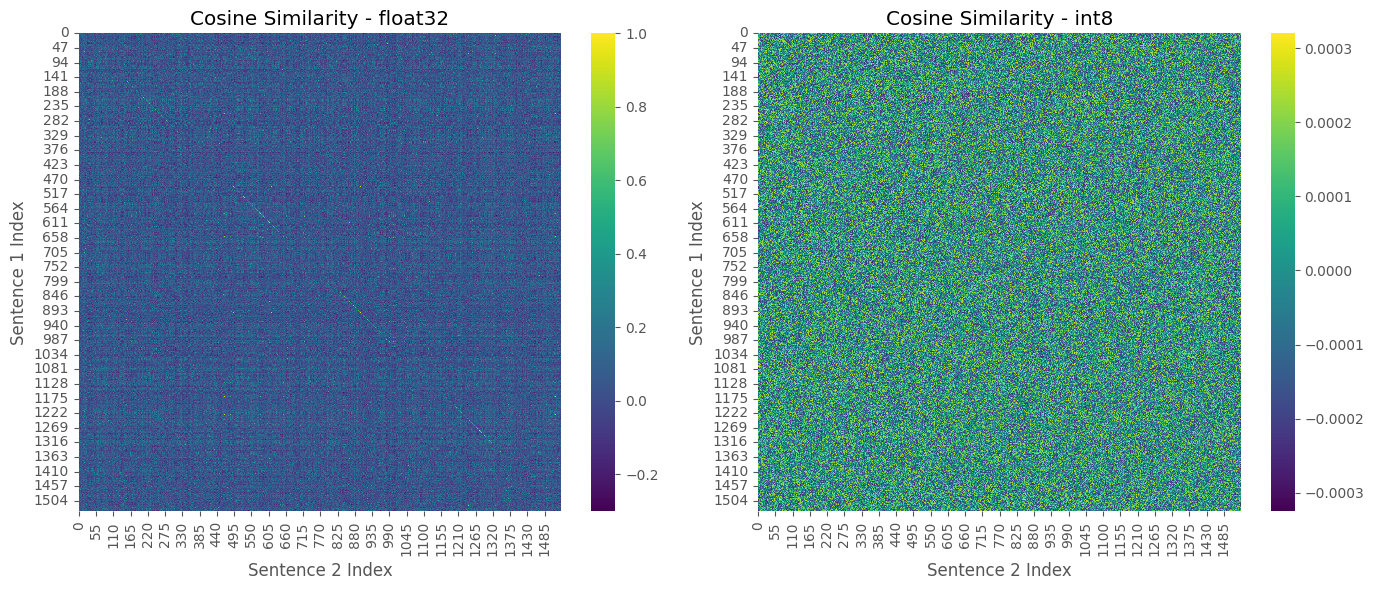

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cos_sim_full, cmap="viridis", annot=False, ax=axes[0])
axes[0].set_title("Cosine Similarity - float32")
axes[0].set_xlabel("Sentence 2 Index")
axes[0].set_ylabel("Sentence 1 Index")

sns.heatmap(cos_sim_binary, cmap="viridis", annot=False, ax=axes[1])
axes[1].set_title("Cosine Similarity - int8")
axes[1].set_xlabel("Sentence 2 Index")
axes[1].set_ylabel("Sentence 1 Index")

plt.tight_layout()
plt.show()

In [25]:
def compute_mrr_hits(similarity_matrix, k_values=[1, 3, 5, 10]):
    num_samples = similarity_matrix.shape[0]
    mrr_scores = []
    hits_scores = {k: [] for k in k_values}

    rankings = np.argsort(-similarity_matrix, axis=1)

    for i in range(num_samples):
        ranked_indices = rankings[i]
        relevant_idx = i

        mrr = 0
        hits = {k: 0 for k in k_values}

        for rank, idx in enumerate(ranked_indices):
            if idx == relevant_idx:
                mrr = 1 / (rank + 1)
                for k in k_values:
                    if rank < k:
                        hits[k] = 1
                break

        mrr_scores.append(mrr)
        for k in k_values:
            hits_scores[k].append(hits[k])

    avg_mrr = np.mean(mrr_scores)
    avg_hits = {k: np.mean(hits_scores[k]) for k in k_values}

    return {"MRR": avg_mrr, **{f"Hits@{k}": avg_hits[k] for k in k_values}}

In [305]:
mrr_hits_binary = compute_mrr_hits(cos_sim_binary, [1, 5, 10, 20])
mrr_hits_full = compute_mrr_hits(cos_sim_full, [1, 5, 10, 20])

In [148]:
print("Binary Embeddings")
print(json.dumps(mrr_hits_binary, indent=4))
print("Full Precision Embeddings")
print(json.dumps(mrr_hits_full, indent=4))

Binary Embeddings
{
    "MRR": 0.00595674164039699,
    "Hits@1": 0.000649772579597141,
    "Hits@5": 0.005198180636777128,
    "Hits@10": 0.007797270955165692,
    "Hits@20": 0.014944769330734242
}
Full Precision Embeddings
{
    "MRR": 0.4228756118497743,
    "Hits@1": 0.34307992202729043,
    "Hits@5": 0.49707602339181284,
    "Hits@10": 0.5763482781026641,
    "Hits@20": 0.6855100714749838
}


In [151]:
# Ideally we would use a calibration set to quantize the embeddings (train/validation/test/calibration split)
scalar_embeddings = quantize_embeddings(
    ds_gte["gte-mnrl_embeddings1"] + ds_gte["gte-mnrl_embeddings2"],
    precision="int8",
    calibration_embeddings=ds_gte["gte-mnrl_embeddings1"][:500]
)

scalar_embeddings1 = scalar_embeddings[:len(ds_gte["gte-mnrl_embeddings1"])]
scalar_embeddings2 = scalar_embeddings[len(ds_gte["gte-mnrl_embeddings1"]):]

In [152]:
ds_gte = ds_gte.add_column("scalar_embeddings1", scalar_embeddings1.tolist())
ds_gte = ds_gte.add_column("scalar_embeddings2", scalar_embeddings2.tolist())

In [153]:
ds_gte

Dataset({
    features: ['sentence1', 'sentence2', 'label', 'gte-mnrl_embeddings1', 'gte-mnrl_embeddings2', 'sim', 'loss', 'binary_embeddings1', 'binary_embeddings2', 'scalar_embeddings1', 'scalar_embeddings2'],
    num_rows: 1539
})

In [154]:
%time
cos_sim_scalar = scalar_embeddings1 @ np.array(scalar_embeddings2).T / (
    np.linalg.norm(scalar_embeddings1, axis=1)[:, None] * np.linalg.norm(scalar_embeddings2, axis=1)[None, :]
)

CPU times: user 8 μs, sys: 1e+03 ns, total: 9 μs
Wall time: 14.3 μs


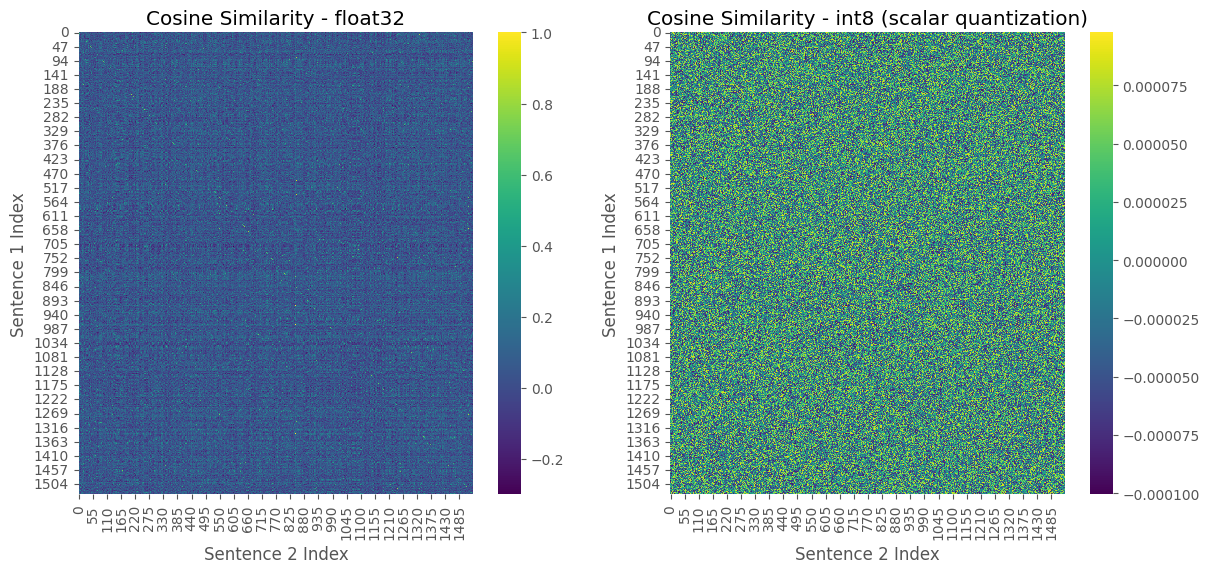

In [156]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cos_sim_full, cmap="viridis", annot=False, ax=axes[0])
axes[0].set_title("Cosine Similarity - float32")
axes[0].set_xlabel("Sentence 2 Index")
axes[0].set_ylabel("Sentence 1 Index")

sns.heatmap(cos_sim_scalar, cmap="viridis", annot=False, ax=axes[1])
axes[1].set_title("Cosine Similarity - int8 (scalar quantization)")
axes[1].set_xlabel("Sentence 2 Index")
axes[1].set_ylabel("Sentence 1 Index")

plt.show()

In [158]:
scalar_mrr_hits = compute_mrr_hits(cos_sim_scalar, [1, 5, 10, 20])

In [159]:
print("Scalar Quantized Embeddings")
print(json.dumps(scalar_mrr_hits, indent=4))

Scalar Quantized Embeddings
{
    "MRR": 0.004413894321211907,
    "Hits@1": 0.0,
    "Hits@5": 0.001299545159194282,
    "Hits@10": 0.004548408057179987,
    "Hits@20": 0.014944769330734242
}


> Okay euh Embeddings Quantization looks very very ba with our embeddings so we won't use them

> We will try a SOTA method for reducing the dimensions of our embedidngs and consequently optimizing the inference time/similarity search speed while keeping good performances

In [248]:
matryoshka_gte = SentenceTransformer("./checkpoints/gte-mat-mnrl/best-model", device="cuda", trust_remote_code=True)

In [249]:
matryoshka_dims = [512, 128, 64]

In [285]:
embeddings_mat = matryoshka_gte.encode(ds_gte["sentence1"] + ds_gte["sentence2"], convert_to_tensor=True, show_progress_bar=False)

In [286]:
embeddings_mat_dict = {
    dim: embeddings_mat.cpu().numpy()[:, :dim]
    for dim in matryoshka_dims
}

In [289]:
embeddings_mat_dict[512][:len(ds_gte["sentence1"])].shape

(1539, 512)

In [296]:
embeddings1 = embeddings_mat_dict[64][:len(ds_gte["sentence1"])]
embeddings2 = embeddings_mat_dict[64][len(ds_gte["sentence1"]):]

%time
cos_sim_64 = embeddings1 @ embeddings2.T / (
    np.linalg.norm(embeddings1, axis=1)[:, None] * np.linalg.norm(embeddings2, axis=1)[None, :]
)

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.77 μs


In [297]:
embeddings1 = embeddings_mat_dict[128][:len(ds_gte["sentence1"])]
embeddings2 = embeddings_mat_dict[128][len(ds_gte["sentence1"]):]

%time
cos_sim_128 = embeddings1 @ embeddings2.T / (
    np.linalg.norm(embeddings1, axis=1)[:, None] * np.linalg.norm(embeddings2, axis=1)[None, :]
)

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.05 μs


In [298]:
embeddings1 = embeddings_mat_dict[512][:len(ds_gte["sentence1"])]
embeddings2 = embeddings_mat_dict[512][len(ds_gte["sentence1"]):]

%time
cos_sim_512 = embeddings1 @ embeddings2.T/ (
    np.linalg.norm(embeddings1, axis=1)[:, None] * np.linalg.norm(embeddings2, axis=1)[None, :]
)

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.77 μs


In [299]:
embeddings1 = embeddings_mat[:len(ds_gte["sentence1"])].cpu().numpy()
embeddings2 = embeddings_mat[len(ds_gte["sentence1"]):].cpu().numpy()

%time
cos_sim_768 = embeddings1 @ embeddings2.T / (
    np.linalg.norm(embeddings1, axis=1)[:, None] * np.linalg.norm(embeddings2, axis=1)[None, :]
)

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.29 μs


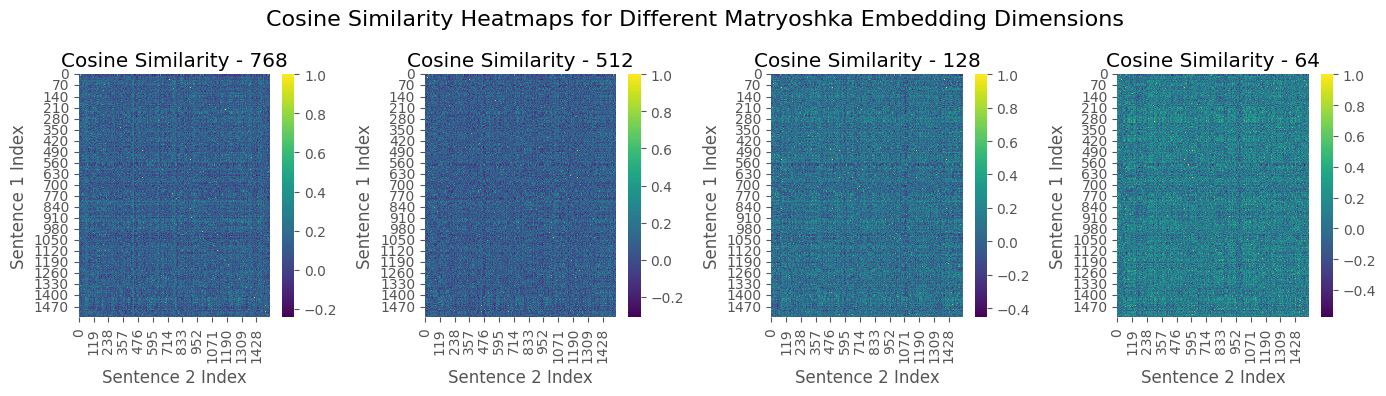

In [300]:
fig, axes = plt.subplots(1, 4, figsize=(14, 4))

sns.heatmap(cos_sim_768, cmap="viridis", annot=False, ax=axes[0])
axes[0].set_title("Cosine Similarity - 768")
axes[0].set_xlabel("Sentence 2 Index")
axes[0].set_ylabel("Sentence 1 Index")

sns.heatmap(cos_sim_512, cmap="viridis", annot=False, ax=axes[1])
axes[1].set_title("Cosine Similarity - 512")
axes[1].set_xlabel("Sentence 2 Index")
axes[1].set_ylabel("Sentence 1 Index")

sns.heatmap(cos_sim_128, cmap="viridis", annot=False, ax=axes[2])
axes[2].set_title("Cosine Similarity - 128")
axes[2].set_xlabel("Sentence 2 Index")
axes[2].set_ylabel("Sentence 1 Index")

sns.heatmap(cos_sim_64, cmap="viridis", annot=False, ax=axes[3])
axes[3].set_title("Cosine Similarity - 64")
axes[3].set_xlabel("Sentence 2 Index")
axes[3].set_ylabel("Sentence 1 Index")

fig.suptitle("Cosine Similarity Heatmaps for Different Matryoshka Embedding Dimensions", fontsize=16)
plt.tight_layout()
plt.show()

> Similarity Matrices look grate for evry dimensions, something that we can notice is that we have less FN with Higher dimension (because the matirx is more dark). It's an interesting insight because if we plan to use dim=64, we can try to put a hugh threshold when we retrieve/approximate th ek nearest neighbours, in order to avoid too much FN.

In [301]:
mrr_hits_768 = compute_mrr_hits(cos_sim_768, [1, 5, 10, 20])
mrr_hits_64 = compute_mrr_hits(cos_sim_64, [1, 5, 10, 20])
mrr_hits_128 = compute_mrr_hits(cos_sim_128, [1, 5, 10, 20])
mrr_hits_512 = compute_mrr_hits(cos_sim_512, [1, 5, 10, 20])

In [302]:
print("768 Embeddings")
print(json.dumps(mrr_hits_768, indent=4))
print("512 Embeddings")
print(json.dumps(mrr_hits_512, indent=4))
print("128 Embeddings")
print(json.dumps(mrr_hits_128, indent=4))
print("64 Embeddings")
print(json.dumps(mrr_hits_64, indent=4))

768 Embeddings
{
    "MRR": 0.41769046510441143,
    "Hits@1": 0.33853151397011044,
    "Hits@5": 0.49317738791423,
    "Hits@10": 0.5685510071474984,
    "Hits@20": 0.6627680311890838
}
512 Embeddings
{
    "MRR": 0.4120756274472134,
    "Hits@1": 0.3333333333333333,
    "Hits@5": 0.4866796621182586,
    "Hits@10": 0.5607537361923327,
    "Hits@20": 0.6556205328135153
}
128 Embeddings
{
    "MRR": 0.388304865014691,
    "Hits@1": 0.31189083820662766,
    "Hits@5": 0.45938921377517866,
    "Hits@10": 0.5386614684860299,
    "Hits@20": 0.6231319038336582
}
64 Embeddings
{
    "MRR": 0.3455347161551195,
    "Hits@1": 0.26900584795321636,
    "Hits@5": 0.42105263157894735,
    "Hits@10": 0.49317738791423,
    "Hits@20": 0.5802469135802469
}


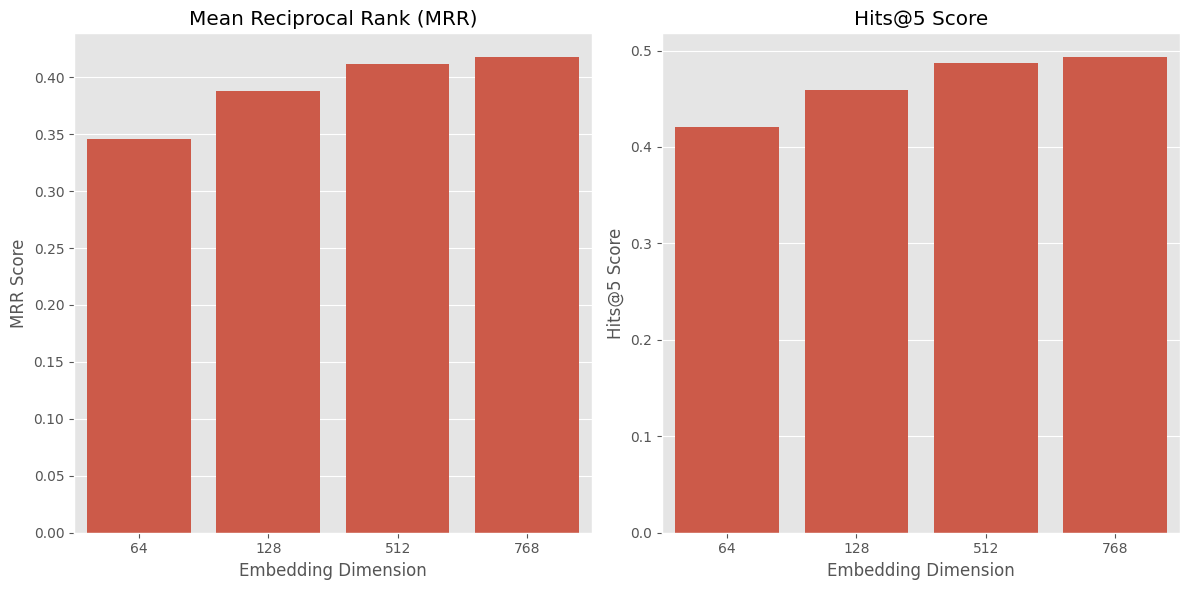

In [308]:
dimensions = ["64", "128", "512", "768"]
mrr_scores = [mrr_hits_64["MRR"], mrr_hits_128["MRR"], mrr_hits_512["MRR"], mrr_hits_768["MRR"]]
hits5_scores = [mrr_hits_64["Hits@5"], mrr_hits_128["Hits@5"], mrr_hits_512["Hits@5"], mrr_hits_768["Hits@5"]]

df_scores = pd.DataFrame({"Dimension": dimensions, "MRR": mrr_scores, "Hits@5": hits5_scores})

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(x="Dimension", y="MRR", data=df_scores, ax=axes[0])
axes[0].set_title("Mean Reciprocal Rank (MRR)")
axes[0].set_xlabel("Embedding Dimension")
axes[0].set_ylabel("MRR Score")

sns.barplot(x="Dimension", y="Hits@5", data=df_scores, ax=axes[1])
axes[1].set_title("Hits@5 Score")
axes[1].set_xlabel("Embedding Dimension")
axes[1].set_ylabel("Hits@5 Score")

plt.tight_layout()
plt.show()

> with a dimension of 512 we have results similar to 768

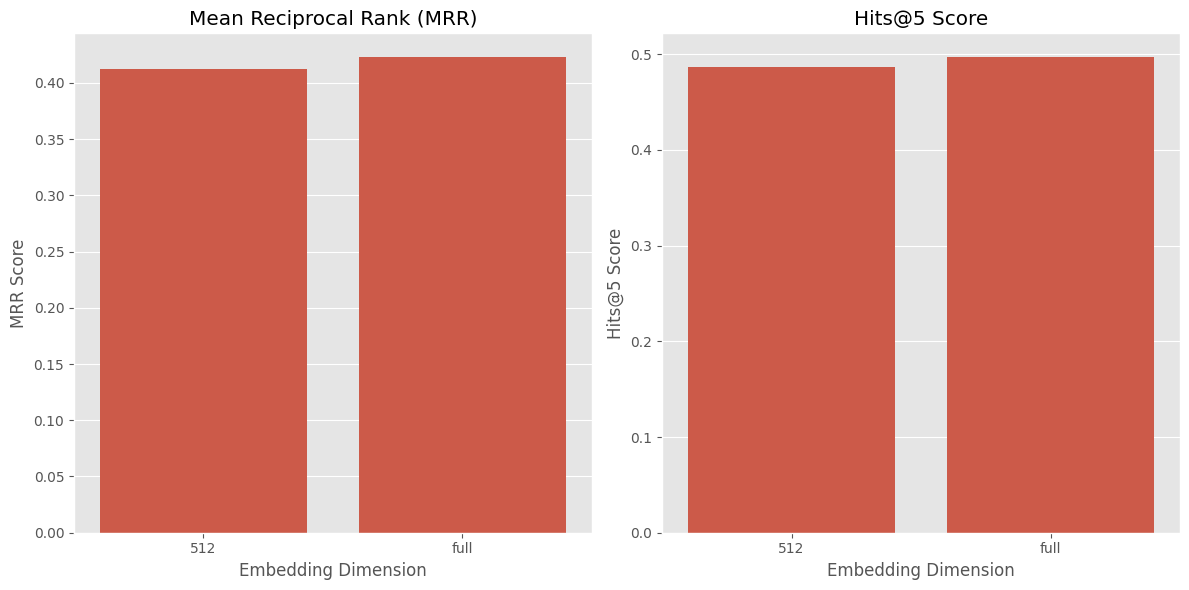

In [309]:
dimensions = ["512", "full"]
mrr_scores = [mrr_hits_512["MRR"], mrr_hits_full["MRR"]]
hits5_scores = [mrr_hits_512["Hits@5"], mrr_hits_full["Hits@5"]]

df_scores = pd.DataFrame({"Dimension": dimensions, "MRR": mrr_scores, "Hits@5": hits5_scores})

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(x="Dimension", y="MRR", data=df_scores, ax=axes[0])
axes[0].set_title("Mean Reciprocal Rank (MRR)")
axes[0].set_xlabel("Embedding Dimension")
axes[0].set_ylabel("MRR Score")

sns.barplot(x="Dimension", y="Hits@5", data=df_scores, ax=axes[1])
axes[1].set_title("Hits@5 Score")
axes[1].set_xlabel("Embedding Dimension")
axes[1].set_ylabel("Hits@5 Score")

plt.tight_layout()
plt.show()

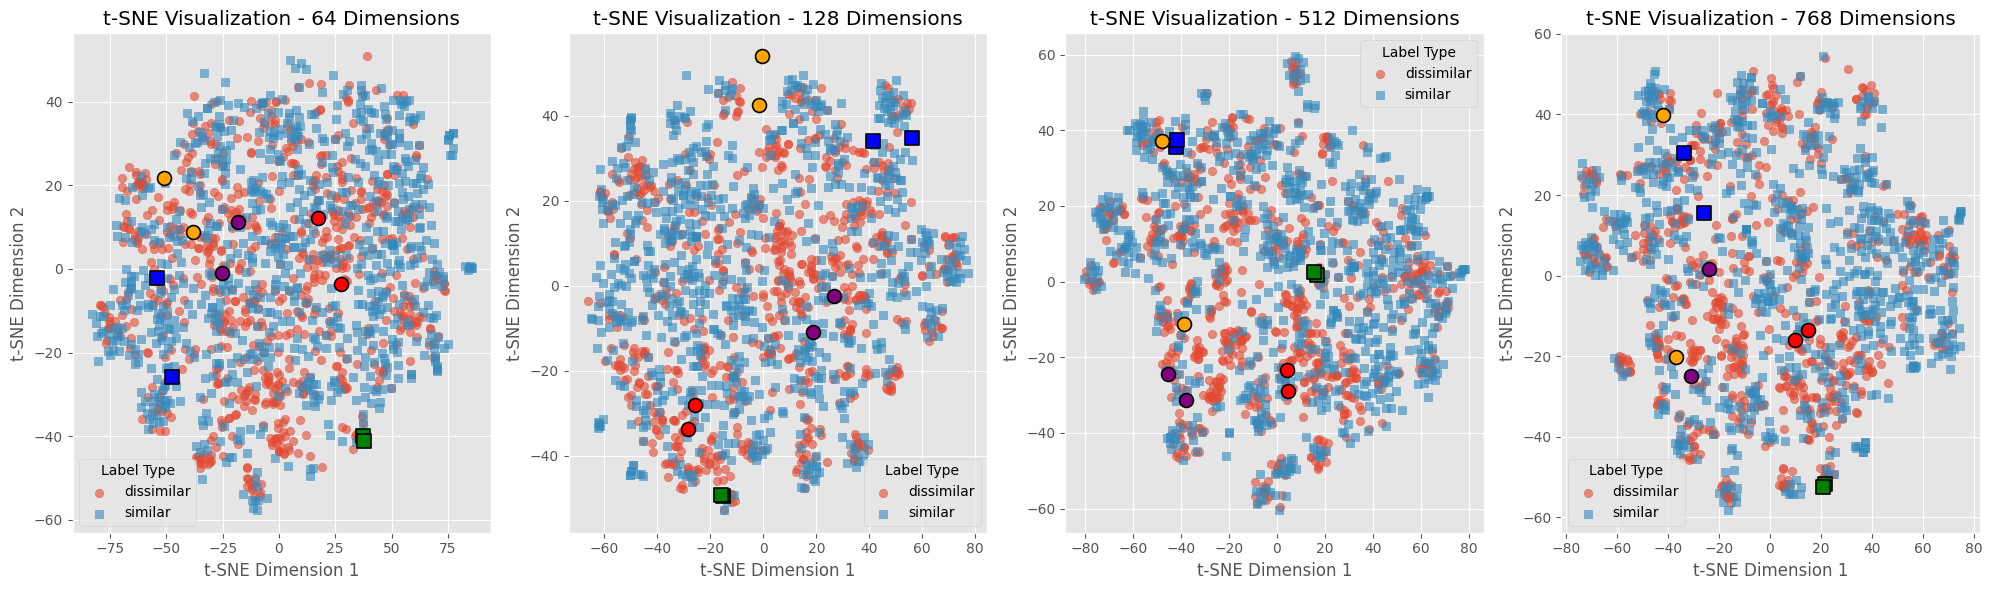

In [311]:
np.random.seed(42)

dimensions = [64, 128, 512]
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

highlight_indices = np.random.choice(len(ds_gte["sentence1"]), 5, replace=False)
highlight_colors = ["red", "blue", "green", "purple", "orange"]

for i, dim in enumerate(dimensions):
    emb_1 = embeddings_mat_dict[dim][:len(ds_gte["sentence1"])]  
    emb_2 = embeddings_mat_dict[dim][len(ds_gte["sentence1"]):]  
    labels = np.array(ds_gte["label"])  

    embeddings = np.vstack((emb_1, emb_2))
    sentence_labels = ["sentence1"] * len(emb_1) + ["sentence2"] * len(emb_2)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    ax = axes[i]
    markers = {0: "o", 1: "s"}

    for label in [0, 1]:
        indices = np.where(labels == label)[0]
        ax.scatter(
            reduced_embeddings[indices, 0], 
            reduced_embeddings[indices, 1], 
            label="similar" if label == 1 else "dissimilar",
            alpha=0.6, 
            marker=markers[label]
        )

    for j, idx in enumerate(highlight_indices):
        marker = markers[labels[idx]]
        ax.scatter(
            reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], 
            color=highlight_colors[j], edgecolors="black", linewidth=1.2, s=100, marker=marker
        )
        ax.scatter(
            reduced_embeddings[len(emb_1) + idx, 0], reduced_embeddings[len(emb_1) + idx, 1], 
            color=highlight_colors[j], edgecolors="black", linewidth=1.2, s=100, marker=marker
        )

    ax.set_title(f"t-SNE Visualization - {dim} Dimensions")
    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")
    ax.legend(title="Label Type")

emb_1 = embeddings_mat.cpu().numpy()[:len(ds_gte["sentence1"])]
emb_2 = embeddings_mat.cpu().numpy()[len(ds_gte["sentence1"]):]
labels = np.array(ds_gte["label"])

embeddings = np.vstack((emb_1, emb_2))
sentence_labels = ["sentence1"] * len(emb_1) + ["sentence2"] * len(emb_2)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

ax = axes[3]
markers = {0: "o", 1: "s"}

for label in [0, 1]:
    indices = np.where(labels == label)[0]
    ax.scatter(
        reduced_embeddings[indices, 0], 
        reduced_embeddings[indices, 1], 
        label="similar" if label == 1 else "dissimilar",
        alpha=0.6, 
        marker=markers[label]
    )

for j, idx in enumerate(highlight_indices):
    marker = markers[labels[idx]]
    ax.scatter(
        reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], 
        color=highlight_colors[j], edgecolors="black", linewidth=1.2, s=100, marker=marker
    )
    ax.scatter(
        reduced_embeddings[len(emb_1) + idx, 0], reduced_embeddings[len(emb_1) + idx, 1], 
        color=highlight_colors[j], edgecolors="black", linewidth=1.2, s=100, marker=marker
    )

ax.set_title("t-SNE Visualization - 768 Dimensions")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.legend(title="Label Type")

plt.tight_layout()
plt.show()

> Dissimilar samples seem well separated with dim=64

> Finally, let's quantize our model with dynamic quantization (because we didn't prepare a calibration dataset) to have the SOTA in term of performances and speed. This model can be used in real case scenario like RAG or Recommander System.

In [18]:
matryoshka_gte = SentenceTransformer("./checkpoints/gte-mat-mnrl/best-model", trust_remote_code=True, backend="onnx", truncate_dim=512)

2025-02-14 00:33:56.354410620 [E:onnxruntime:Default, env.cc:234 ThreadMain] pthread_setaffinity_np failed for thread: 1303134, index: 0, mask: {4, 28, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2025-02-14 00:33:56.363543046 [E:onnxruntime:Default, env.cc:234 ThreadMain] pthread_setaffinity_np failed for thread: 1303149, index: 15, mask: {7, 31, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2025-02-14 00:33:56.368790889 [E:onnxruntime:Default, env.cc:234 ThreadMain] pthread_setaffinity_np failed for thread: 1303150, index: 16, mask: {3, 27, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2025-02-14 00:33:56.374503022 [E:onnxruntime:Default, env.cc:234 ThreadMain] pthread_setaffinity_np failed for thread: 1303146, index: 12, mask: {5, 29, }, error code: 22 error msg: Invalid argu

In [19]:
export_dynamic_quantized_onnx_model(matryoshka_gte, "avx512_vnni", "./checkpoints/gte-mat-mnrl")

In [20]:
del matryoshka_gte
gc.collect()
torch.cuda.empty_cache()